# 3- Statistical Analysis
This section will further analyze our wrangle datasets by using inferential statistics to conduct hypothesis tests.

In [4]:
#import data manipulation packages
import pandas as pd
import numpy as np

#import visualisation tools
import matplotlib.pyplot as plt
import seaborn as sns

#import pickle to loan our datatyes
import pickle
sns.set()

In [5]:
#loading the datatypes dictionary
with open("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\notebooks\\2-wrangling\\data_types.pkl", 'rb') as f:
    data_types = pickle.load(f)

In [6]:
#loading the training features
X_train=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\X_train_new.csv", low_memory=False, index_col=0, dtype=data_types)

C:\Users\yfawz\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
#loading the testing features
X_test=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\X_test_new.csv",low_memory=False, index_col=0, dtype=data_types)

In [8]:
#loading the training and testing target variable
y_train=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\y_train_new.csv", low_memory=False, index_col=0)
y_test=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\y_test_new.csv", low_memory=False, index_col=0)

Let's have a quick look at the data to make sure everything is okay.

In [9]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,8000,8000,8000.0,36 months,10.99,261.880005,B,B2,assistant,10+ years,...,50.0,0.0,0.0,11100.0,8116.0,7800.0,0.0,N,Cash,N
1,3900,3900,3900.0,36 months,12.99,131.389999,C,C1,health,6 years,...,0.0,1.0,0.0,25881.0,10129.0,7750.0,13531.0,N,Cash,N
2,18000,18000,18000.0,60 months,7.97,364.720001,A,A5,senior,10+ years,...,0.0,0.0,0.0,305986.0,82784.0,35600.0,117986.0,N,Cash,N
3,3500,3500,3500.0,36 months,15.02,121.370003,C,C3,federal,10+ years,...,75.0,1.0,0.0,71470.0,51208.0,3500.0,67970.0,N,Cash,N
4,22000,22000,21950.0,36 months,7.62,685.549988,A,A3,other,9 years,...,25.0,0.0,0.0,345978.0,44605.0,17700.0,50928.0,N,Cash,N


## Introduction

- The hypothesis that will be done in this notebook will compare 2 distributions and whether they are identical.
- The tests will follow the same computational path and therefore we will write functions to ease this analysis.

## Function Definition
- The aim is to compare 2 different distributions and see if they are similar.
- This can be done by conducting a hypotheis test with permutations using the following functions:

#### 1. The first function will:
1. Combine the 2 datasets together
2. Randomly scramble the data so that the original order is lost. 
3. Divide the scramble data into 2 portions. Each portion is the same length as the original. Except now they are from the scrambled set.
4. The function will return the 2 permutated samples of the scrambled data

#### 2. The second function will:
1. Draw permutated samples using the first function.
2. Apply a pre-defined function that takes 2 sets as inputs and returns a permutated replicate.(In this scenario the function will be the difference of means which will be our 3rd function.
3. There will be a 'size' argument which will be the number of iterations(# of replicates) to be returned by the function. 

#### 3. The third funtion will be:
1. This is our 'pre-defined' funtion
2. Return the difference of means between two datasets.

- Combinging the 3 functions will return one array of permutated replicates(difference of means) 
- Can be used to test the observed difference against the replicates to complete the hypothesis test.
- We will use the p-value to reject or fail to reject the null hypothesis

The p-value which is the probability of observing a test statistic equally or more extreme than the one observed, given that the null hypothesis is true.

In [10]:
def permutation_sample(set_1, set_2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((set_1, set_2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(set_1)]
    perm_sample_2 = permuted_data[-len(set_2):]

    return perm_sample_1, perm_sample_2

In [11]:
# Defining function to return permutaed samples depending on function
def draw_perm_reps(set_1, set_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_reps = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(set_1,set_2)

        # Compute the test statistic
        perm_reps[i] = func(perm_sample_1, perm_sample_2)

    return perm_reps

In [12]:
def diff_of_means(set_1, set_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(set_1) - np.mean(set_2)
    
    return diff

Now that our functions are ready, we can start testing

# 1. Do mortgage holders have a different interest rate distribution as those who own their homes?

## Null Hypothesis: Mortgage Holders and Owners have the same interest rate distribution.

- Start by filtering the mortgage holder and home owner data.
- Select the interest rates column.

In [13]:
#Filtering Mortgage Data
mortgage_data=X_train[X_train.home_ownership == 'MORTGAGE']

#Filterting Owner data
owner_data=X_train[X_train.home_ownership == 'OWN']

#Selecting interest rates
ir_mortgage=mortgage_data['int_rate']
ir_owner=owner_data['int_rate']

What is the observed difference of means?

In [14]:
# Compute difference of mean interest rates observed in the data
ir_empirical_diff_means = diff_of_means(ir_mortgage,ir_owner)

np.abs(ir_empirical_diff_means)

0.38210010528564453

The observed difference of means between mortgage holders and renters is 0.38%. 
Let's visualize how they differ in a boxplot before testing.

In [17]:
#create a dataframe to create a box plot
df=pd.DataFrame(pd.concat((ir_mortgage, ir_owner)))
df['mort_own']=np.nan
df['mort_own'].iloc[:len(ir_mortgage)]='MORT'
df['mort_own']=df['mort_own'].fillna('OWNER')

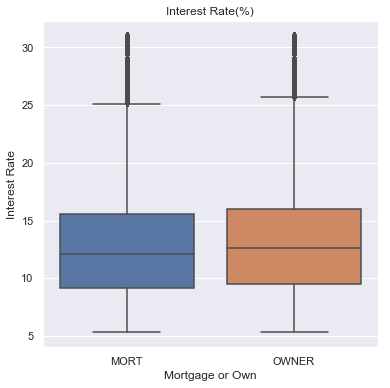

In [16]:
plt.figure(figsize=[6,6])
# Make bee swarm plot
sns.boxplot(x='mort_own', y='int_rate', data=df)

# Label axes
plt.xlabel('Mortgage or Own')
plt.ylabel('Interest Rate')
plt.title('Interest Rate(%)');

As the difference of means showed us, Owners seem to have a 0.36% higher mean interest rate than mortgage holders. But it's quite difficult to conclude as they are very close distributions. 

Let's run our test

In [19]:
# Draw 2,000 permutation replicates: perm_replicates
perm_reps = draw_perm_reps(ir_mortgage, ir_owner, diff_of_means, size=2000)

# Compute p-value: p
p = np.sum(np.abs(perm_reps) >= np.abs(ir_empirical_diff_means)) / len(perm_reps)

# Print the result
print('p-value =', p)

p-value = 0.0


- p-value is 0.

This p-value the probability of getting at least a 0.38% difference in mean interest rate under the hypothesis that the distributions of interest rates are identical. That probability is 0.

- Conclusion:
We reject the null hypothesis as it is statistically significantly different than what we observed under the null hypothesis.
We can safely assume that mortgage holders and owners can be assumed to have the same interest rate distribution.

How does the observed difference look like compared to the distribution?

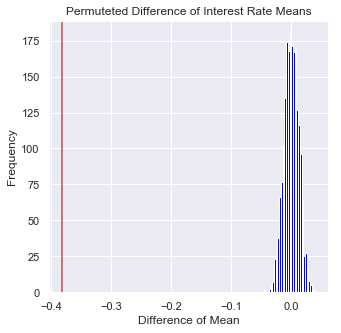

In [20]:
plt.figure(figsize=[5,5])
plt.hist(perm_reps, bins=30, color='blue')
plt.axvline(x=ir_empirical_diff_means, color='r')

plt.title("Permuteted Difference of Interest Rate Means")
plt.xlabel("Difference of Mean")
plt.ylabel("Frequency");

We see that the observed difference is very far off the distribution. To conclude,

Mortgage Holders and Owners do not have the same interest rate distribution

# 2. Do mortgage holders have different distributions of loans vs those who rent their homes?

# Null Hypothesis: Mortgage Holders and Renters have the same loan value distribution.

Let select the loan_amnt column represnting loan values.

In [22]:
#filtering renter data
renter_data=X_train[X_train.home_ownership == 'RENT']

#selecting loan_amnt features
loan_mortgage=mortgage_data['loan_amnt']
loan_renter=renter_data['loan_amnt']

Now let's compute the observed difference of means

In [80]:
# Compute difference of mean loan values observed in the data
loan_empirical_diff_means = diff_of_means(loan_mortgage,loan_renter)

np.abs(loan_empirical_diff_means)

3494.7910755136254

The observed difference of means between mortgage holders and renters is 3496 dollars. Is this significant?

Let's visualize how they differ in a boxplot before testing.

In [24]:
#creatingt a dataframe to ease boxplot creation
df_1=pd.DataFrame(pd.concat((loan_mortgage, loan_renter)))
df_1['mort_rent']=np.nan
df_1['mort_rent'].loc[:len(ir_mortgage)]='MORT'
df_1['mort_rent']=df_1['mort_rent'].fillna('RENT')

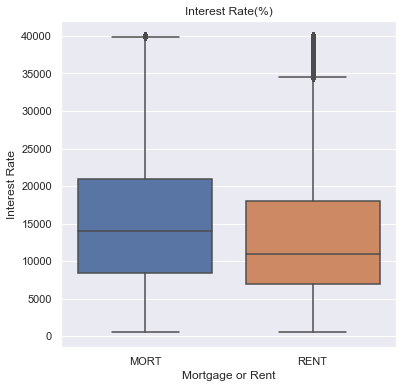

In [25]:
plt.figure(figsize=[6,6])
# Make box plot
sns.boxplot(x='mort_rent', y='loan_amnt', data=df_1)

# Label axes
plt.xlabel('Mortgage or Rent')
plt.ylabel('Interest Rate')
plt.title('Interest Rate(%)');

Mortgager holder indeed have a wider range than rent as well as a higher mean but let's confirm this with our hypothesis test.

In [81]:
# Draw 2,000 permutation replicates: perm_replicates
perm_reps = draw_perm_reps(loan_mortgage, loan_mortgage, diff_of_means, size=2000)

# Compute p-value: p
p = np.sum(np.abs(perm_reps) >= np.abs(loan_empirical_diff_means)) / len(perm_reps)

# Print the result
print('p-value =', p)

p-value = 0.0


- We reject the null hypothesis
- Mortgage Holders and Renters have the same loan value distribution.

# 3. Is interest rate distribution the same for all loan Status (Bad vs Good)?

## Null Hypothesis: Bad and Good Loans have the same interest rate distribution.¶

The training set is either good or bad. We will use a mask from the target variable to select interest rate.

In [63]:
#using a mask from target variable to select features in training set
ir_late=X_train.loc[y_train[y_train.loan_status=='bad'].index]['int_rate']
ir_good=X_train.loc[y_train[y_train.loan_status=='good'].index]['int_rate']

Before we start our testing, what is the observed difference of the means?

In [64]:
# Compute difference of mean interest rates observed in the data
ir_empirical_diff_means = diff_of_means(ir_late,ir_good)

np.abs(ir_empirical_diff_means)

3.0181684494018555

We see that there is a 3% difference diffence in the mean of the interest rate. Is this significant compared to the distribution. We can predict that it will be significant as this is 10x the value of the previous section.

In [113]:
df_2=pd.DataFrame(pd.concat((ir_late, ir_good)))
df_2['bad_good']=np.nan
df_2['bad_good'].iloc[:len(ir_late)]='BAD'
df_2['bad_good']=df_2['bad_good'].fillna('GOOD')

C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


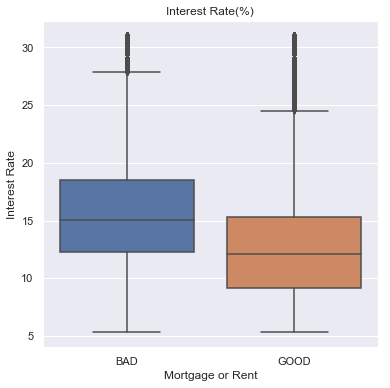

In [114]:
plt.figure(figsize=[6,6])
# Make bee swarm plot
sns.boxplot(x='bad_good', y='int_rate', data=df_2)

# Label axes
plt.xlabel('Mortgage or Rent')
plt.ylabel('Interest Rate')
plt.title('Interest Rate(%)');

There is indeed a visually significant difference between bad and good loans. Let's confirm with a hypothesis test.

In [67]:
# Draw 2,000 permutation replicates: perm_replicates
perm_reps = draw_perm_reps(ir_late, ir_good, diff_of_means, size=2000)

# Compute p-value: p
p = np.sum(np.abs(perm_reps) >= np.abs(ir_empirical_diff_means)) / len(perm_reps)

# Print the result
print('p-value =', p)

p-value = 0.0


- We reject the null hypothesis
- Bad and Good Loans have the same interest rate distribution.¶

# 4. Is loan amount distribution the same for all loan Status (Bad vs Good)?

## Null Hypothesis: Bad and good Loans have the same loan amount distribution.

In [84]:
loan_late=X_train.loc[y_train[y_train.loan_status=='bad'].index]['loan_amnt']
loan_good=X_train.loc[y_train[y_train.loan_status=='good'].index]['loan_amnt']

In [85]:
# Compute difference of mean interest rates observed in the data
loan_empirical_diff_means = diff_of_means(loan_late,loan_good)

np.abs(loan_empirical_diff_means)

748.572396093763

In [86]:
df_3=pd.DataFrame(pd.concat((loan_late, loan_good)))
df_3['bad_good']=np.nan
df_3['bad_good'].iloc[:len(ir_late)]='BAD'
df_3['bad_good']=df_2['bad_good'].fillna('GOOD')

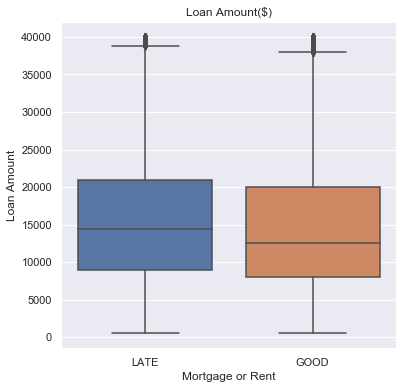

In [87]:
plt.figure(figsize=[6,6])
# Make box plot
sns.boxplot(x='bad_good', y='loan_amnt', data=df_3)

# Label axes
plt.xlabel('Mortgage or Rent')
plt.ylabel('Loan Amount')
plt.title('Loan Amount($)');

We see that visually, the difference cannot be concluded. Let's run the test.

In [89]:
# Draw 2,000 permutation replicates: loan_good_late_perm_replicates
loan_good_bad_perm_reps = draw_perm_reps(loan_late, loan_good, diff_of_means, size=2000)

# Compute p-value: p
p = np.sum(np.abs(loan_good_bad_perm_reps) >= np.abs(loan_empirical_diff_means)) / len(loan_good_bad_perm_reps)

# Print the result
print('p-value =', p)

p-value = 0.0


- We reject the null hypothesis 
- Bad and good Loans do not have the same loan amount distribution.